In [3]:
# !pip install textblob
# !pip install tweepy
# !pip install gzip

import numpy as np
import pandas as pd
import wordcloud
import matplotlib.pyplot as plt
import os
import gzip
import json
%matplotlib inline
from time import perf_counter

import textblob
import tweepy
import nltk
# nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Useful Functions

In [98]:
def my_random_forest_report(cv_results, n_top=3):
    '''
    cv_results: Takes the randomForest_object.cv_results_
    n_top: No of top results to be displayed
    
    Description:
        randomForest_object.cv_results_ gives a long list of attributes.
        This report function retuns only the top n from results from that big list in a graspable format.
    '''
    for i in range(1,n_top+1,1):
        rank_indices = np.flatnonzero(cv_results["rank_test_score"]==i)
        # the following loop is made because there can be one or more elements of the same rank
        for rank_index in rank_indices:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                cv_results["mean_test_score"][rank_index],
                cv_results["std_test_score"][rank_index]))
            print("Parameters: {0}".format(cv_results["params"][rank_index]))
            print("")

## Data Explorations

In [82]:
tweets = pd.read_csv(r"Sentiment Analysis Dataset.csv")
tweets = tweets[["SentimentText", "Sentiment"]]
tweets_p, tweets_n = tweets[tweets["Sentiment"] == 1], tweets[tweets["Sentiment"] == 0]
tweets

,SentimentText,Sentiment
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,1
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0
...,...,...
1578591,Zzzzzz.... Finally! Night tweeters!,1
1578592,"Zzzzzzz, sleep well people",1
1578593,ZzzZzZzzzZ... wait no I have homework.,0
1578594,"ZzZzzzZZZZzzz meh, what am I doing up again?",0


In [83]:
np.sum(tweets["Sentiment"])/tweets.shape[0]

0.5005492222202514

In [84]:
t_t_pos_nos = np.random.randint(low = 0, high = tweets_p.shape[0], size = 25000)
t_t_neg_nos = np.random.randint(low = 0, high = tweets_n.shape[0], size = 25000)

tweets_p = tweets_p.iloc[t_pos_nos]
tweets_n = tweets_n.iloc[t_neg_nos]

t_tweet_p, v_tweet_p =  train_test_split(tweets_p, test_size = 5000)
t_tweet_n, v_tweet_n =  train_test_split(tweets_n, test_size = 5000)

tweets_train =  pd.concat([t_tweet_p, t_tweet_n], axis = 0, ignore_index = True)
tweets_train = tweets_train.sample(frac=1, random_state = 123).reset_index(drop=True)

tweets_val =  pd.concat([v_tweet_p, v_tweet_n], axis = 0, ignore_index = True)
tweets_val = tweets_val.sample(frac=1, random_state = 123).reset_index(drop=True)

In [88]:
tweets = pd.concat([tweets_train, tweets_val], axis = 0, ignore_index = True)

In [26]:
lemma = WordNetLemmatizer()
stp_wds = set(stopwords.words("english")+list(punctuation))

# stp_wds_pos = stp_wds.union(set(opinion_lexicon.positive()))
# stp_wds_neg = stp_wds.union(set(opinion_lexicon.negative()))
stp_wds

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [8]:
all_text = " ".join(list(tweets["SentimentText"]))
pos_text = " ".join(list(tweets.loc[tweets["Sentiment"] == 1, ["SentimentText"]]["SentimentText"]))
neg_text = " ".join(list(tweets.loc[tweets["Sentiment"] == 0, ["SentimentText"]]["SentimentText"]))

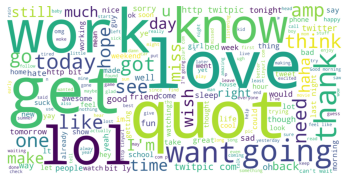

In [30]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(all_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

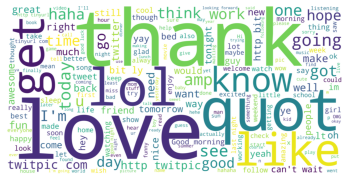

In [46]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(pos_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

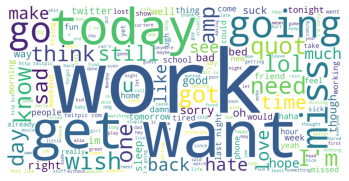

In [47]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(neg_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

## Text Cleaning

In [52]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [10]:
tweets[["SentimentText"]]

,SentimentText
0,is so sad for my APL frie...
1,I missed the New Moon trail...
2,omg its already 7:30 :O
3,.. Omgaga. Im sooo im gunna CRy. I'...
4,i think mi bf is cheating on me!!! ...
...,...
49995,@ashsimpsonwentz this confused me 4 a min... h...
49996,@ashsimpsonwentz: oh so cute! Thank you for sh...
49997,@ashsnl2005 they are giving away red velvet ag...
49998,@AshSoPrecious Where were u @? Didn't know u w...


## Formula based method

In [161]:
t_f_start = perf_counter()

senti_pred = []
for i in list(tweets_val["SentimentText"]):

    this = pos_neg(get_lem(i))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

Elapsed time during the whole program in seconds: 15504.6630095


In [162]:
roc_auc_score(tweets_val["Sentiment"],senti_pred), accuracy_score(tweets_val["Sentiment"],senti_pred)

(0.6175631822928198, 0.65303)

In [ ]:
classification_report(tweets_val["Sentiment"],senti_pred)

In [24]:
temp = get_lem(all_text)
len(temp)

13321823

In [9]:
temp = get_lem(all_text)
len(temp)

429955

In [93]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [143]:
tweets_train.shape[0], min_df_c, max_df_c

(80000, 200, 39800)

In [94]:
t_countv_start = perf_counter()

countv.fit(tweets_train["SentimentText"])
tweets_train_countv = countv.transform(tweets_train["SentimentText"])
tweets_val_countv = countv.transform(tweets_val["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 23.83381450000161


In [95]:
len(countv.vocabulary_)

13418

In [146]:
np.sum(list(countv.vocabulary_.values()))

77470128

## Logistic Regression

In [96]:
t_lr_start = perf_counter()

lr_model_tw = LogisticRegression(class_weight="balanced")
param_lr_model_tw = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_tw = GridSearchCV(estimator=lr_model_tw, param_grid=param_lr_model_tw,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_stop-t_lr_start)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Elapsed time for Logistic Regression Grid Search in seconds: 7.535933199997089


In [ ]:
my_random_forest_report(grid_search_lr_model_tw.cv_results_, n_top = 10)

In [6]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0)

In [7]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_stop-t_lr_start)

NameError: name 'tweets_train_countv' is not defined

In [149]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_stop-t_lr_start)

Elapsed time for Naive Bayes predictions in seconds: 0.0025824000003922265


In [150]:
roc_auc_score(tweets_val["Sentiment"], lr_pred), accuracy_score(tweets_val["Sentiment"], lr_pred)

(0.7423026872275359, 0.7476)

In [ ]:
classification_report(tweets_val["Sentiment"],lr_pred)

## Naive-Bayes

In [ ]:
t_nb_start = perf_counter()

nb_model_tw = MultinomialNB()
param_nb_model_tw = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_tw = RandomizedSearchCV(estimator=nb_model_tw, param_distributions=param_nb_model_tw,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_nb_stop-t_nb_start)

In [ ]:
my_random_forest_report(random_search_nb_model_tw.cv_results_, n_top = 10)

In [5]:
mnb = MultinomialNB(alpha = 1.0)

In [148]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, tweets_train["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.014804300000832882


In [149]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.0025824000003922265


In [150]:
roc_auc_score(tweets_val["Sentiment"], mnb_pred), accuracy_score(tweets_val["Sentiment"], mnb_pred)

(0.7423026872275359, 0.7476)

In [ ]:
classification_report(tweets_val["Sentiment"],mnb_pred)

## SVM

In [ ]:
t_svm_start = perf_counter()

svm_model_tw = SVC()
param_svm_model_tw = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "poly", "sigmoid", "linear"],
                     "degree" : [1,2,3,4,5,6]
                      }

grid_search_svm_model_tw = GridSearchSV(estimator=svm_model_tw, param_grid=param_svm_model_tw,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

In [ ]:
my_random_forest_report(grid_search_svm_model_tw.cv_results_, n_top = 10)

In [151]:
suppor_vect = SVC()

In [152]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 1234.2377228999994


In [153]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 103.31341299999985


In [154]:
roc_auc_score(tweets_val["Sentiment"], suppor_vect_pred)

0.7392185568351877

In [ ]:
classification_report(tweets_val["Sentiment"],suppor_vect_pred)

## XGBoost

In [ ]:
t_xgb_start = perf_counter()

xgb_model_tw = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_tw = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_tw = RandomizedSearchCV(estimator=xgb_model_tw, param_distributions=param_xgb_model_tw,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

In [ ]:
my_random_forest_report(random_search_xgb_model_tw.cv_results_, n_top = 10)

In [155]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 8)

In [156]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

C:\Users\iamen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:47:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time for XGB training in seconds 3.4995104000008723


In [157]:
t_svm_stop = perf_counter()

print("Elapsed time during the whole program in seconds:", t_svm_stop-t_svm_start)

Elapsed time during the whole program in seconds: 106.873963


In [158]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 0.0930638000008912


In [159]:
roc_auc_score(tweets_val["Sentiment"], xgb_pred), accuracy_score(tweets_val["Sentiment"], xgb_pred)

(0.7052073166764267, 0.72525)

In [ ]:
classification_report(tweets_val["Sentiment"],xgb_pred)

# IMDB

In [17]:
files_train_pos = os.listdir(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\train\pos")
files_train_neg = os.listdir(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\train\neg")
files_test_pos = os.listdir(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\test\pos")
files_test_neg = os.listdir(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\test\neg")
print(files_train_pos)
print(len(files_train_pos), len(files_train_neg), len(files_test_pos), len(files_test_neg))

['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt', '10004_8.txt', '10005_7.txt', '10006_7.txt', '10007_7.txt', '10008_7.txt', '10009_9.txt', '1000_8.txt', '10010_7.txt', '10011_9.txt', '10012_8.txt', '10013_7.txt', '10014_8.txt', '10015_8.txt', '10016_8.txt', '10017_9.txt', '10018_8.txt', '10019_8.txt', '1001_8.txt', '10020_8.txt', '10021_8.txt', '10022_7.txt', '10023_9.txt', '10024_9.txt', '10025_9.txt', '10026_7.txt', '10027_7.txt', '10028_10.txt', '10029_10.txt', '1002_7.txt', '10030_10.txt', '10031_10.txt', '10032_10.txt', '10033_10.txt', '10034_8.txt', '10035_9.txt', '10036_8.txt', '10037_9.txt', '10038_10.txt', '10039_10.txt', '1003_10.txt', '10040_10.txt', '10041_10.txt', '10042_10.txt', '10043_10.txt', '10044_9.txt', '10045_10.txt', '10046_9.txt', '10047_10.txt', '10048_10.txt', '10049_8.txt', '1004_7.txt', '10050_10.txt', '10051_10.txt', '10052_10.txt', '10053_8.txt', '10054_10.txt', '10055_7.txt', '10056_8.txt', '10057_9.txt', '10058_7.txt', '10059_10.tx

In [18]:
train_pos, train_neg, test_pos, test_neg = [], [], [], []
for i in range(len(files_train_pos)):
    with open(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\train\pos\\"+files_train_pos[i],"r", encoding="utf8") as f:
        train_pos.append(f.read())
        
    with open(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\train\neg\\"+files_train_neg[i],"r", encoding="utf8") as f:
        train_neg.append(f.read())
        
    with open(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\test\pos\\"+files_test_pos[i],"r", encoding="utf8") as f:
        test_pos.append(f.read())
        
    with open(r"D:\I\OneDrive\edvance\Machine_Learning_Using_Python\Senti\aclImdb\test\neg\\"+files_test_neg[i],"r", encoding="utf8") as f:
        test_neg.append(f.read())


In [19]:
print(len(train_pos),len(train_neg), len(test_pos), len(test_neg))

12500 12500 12500 12500


In [24]:
train_pos

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [20]:
train_pd = pd.DataFrame({"SentimentText": train_pos+train_neg, "Sentiment":np.concatenate([np.ones(len(train_pos)), np.zeros(len(train_neg))]).astype(int)})
val_pd = pd.DataFrame({"SentimentText": test_pos+test_neg, "Sentiment":np.concatenate([np.ones(len(test_pos)), np.zeros(len(test_neg))]).astype(int)})

train_pd, val_pd = train_pd.sample(frac=1, random_state = 123).reset_index(drop=True), val_pd.sample(frac=1, random_state = 123).reset_index(drop=True)

In [21]:
val_pd

,SentimentText,Sentiment
0,this film had a lot of potential - it's a grea...,0
1,"Based on a William Faulkner short story, Two S...",1
2,Screened this morning for the press at Roma fi...,1
3,Pathetic NRI Crap.....Appeal to all who are no...,0
4,This is a surprisingly great low budget Horror...,1
...,...,...
24995,"These days, writers, directors and producers a...",0
24996,"A sadly predictable, clichéd story about a wom...",0
24997,CRAP! I accidentally watched this film-thinkin...,0
24998,It says a lot about the United Kingdom when te...,0


## Text Cleaning

In [23]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [24]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [27]:
t_countv_start = perf_counter()

countv.fit(train_pd["SentimentText"])
tweets_train_countv = countv.transform(train_pd["SentimentText"])
tweets_val_countv = countv.transform(val_pd["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 185.5667100999999


In [28]:
len(countv.vocabulary_)

48289

## Formula based method

In [ ]:
t_f_start = perf_counter()

senti_pred = []
for i in list(val_pd["SentimentText"]):

    this = pos_neg(get_lem(i))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

In [ ]:
roc_auc_score(val_pd["Sentiment"],senti_pred), accuracy_score(val_pd["Sentiment"],senti_pred)

In [ ]:
classification_report(val_pd["Sentiment"],senti_pred)

## Logistic Regression

In [ ]:
t_lr_start = perf_counter()

lr_model_imdb = LogisticRegression(class_weight="balanced")
param_lr_model_imdb = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_imdb = GridSearchCV(estimator=lr_model_imdb, param_grid=param_lr_model_imdb,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_imdb.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_start-t_lr_stop)

In [ ]:
my_random_forest_report(grid_search_lr_model_imdb.cv_results_, n_top = 10)

In [6]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0)

In [7]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_start-t_lr_stop)

NameError: name 'tweets_train_countv' is not defined

In [149]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_start-t_lr_stop)

Elapsed time for Naive Bayes predictions in seconds: 0.0025824000003922265


In [150]:
roc_auc_score(val_pd["Sentiment"], lr_pred), accuracy_score(val_pd["Sentiment"], lr_pred)

(0.7423026872275359, 0.7476)

In [ ]:
classification_report(val_pd["Sentiment"],lr_pred)

## Naive Bayes

In [ ]:
t_nb_start = perf_counter()

nb_model_imdb = MultinomialNB()
param_nb_model_imdb = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_imdb = RandomizedSearchCV(estimator=nb_model_imdb, param_distributions=param_nb_model_imdb,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_imdb.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_nb_stop-t_nb_start)

In [ ]:
my_random_forest_report(random_search_nb_model_imdb.cv_results_, n_top = 10)

In [54]:
mnb = MultinomialNB(alpha = 1.0)

In [8]:
RandomizedSearchCV?

In [55]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, train_pd["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.020677700000305776


In [56]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.02366650000021764


In [57]:
roc_auc_score(val_pd["Sentiment"], mnb_pred), accuracy_score(val_pd["Sentiment"], mnb_pred)

(0.82448, 0.82448)

In [ ]:
classification_report(val_pd["Sentiment"],mnb_pred)

## SVM

In [ ]:
t_svm_start = perf_counter()

svm_model_imdb = SVC()
param_svm_model_imdb = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "poly", "sigmoid", "linear"],
                     "degree" : [1,2,3,4,5,6]
                      }

grid_search_svm_model_imdb = GridSearchSV(estimator=svm_model_imdb, param_grid=param_svm_model_imdb,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_imdb.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

In [ ]:
my_random_forest_report(grid_search_svm_model_imdb.cv_results_, n_top = 10)

In [58]:
suppor_vect = SVC()

In [59]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, train_pd["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 825.4776800999998


In [60]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 335.76952510000046


In [61]:
roc_auc_score(val_pd["Sentiment"], suppor_vect_pred), accuracy_score(val_pd["Sentiment"],suppor_vect_pred)

(0.86952, 0.86952)

In [ ]:
classification_report(val_pd["Sentiment"],suppor_vect_pred)

## XGBoost

In [ ]:
t_xgb_start = perf_counter()

xgb_model_imdb = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_imdb = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_imdb = RandomizedSearchCV(estimator=xgb_model_imdb, param_distributions=param_xgb_model_imdb,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_imdb.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

In [ ]:
my_random_forest_report(random_search_xgb_model_imdb.cv_results_, n_top = 10)

In [38]:
?XGBClassifier

In [33]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 8)

In [34]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, train_pd["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 13.696460400000433


In [35]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 0.8848702999985107


In [36]:
roc_auc_score(val_pd["Sentiment"], xgb_pred), accuracy_score(val_pd["Sentiment"], xgb_pred)

(0.8566799999999999, 0.85668)

In [ ]:
classification_report(val_pd["Sentiment"],xgb_pred)

# Amazon Movies and TV

In [4]:
data = []
with gzip.open(r"D:\not_so_cloud\rohit\senti\Movies_and_TV_5.json.gz") as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

3410019
{'overall': 5.0, 'verified': True, 'reviewTime': '11 9, 2012', 'reviewerID': 'A2M1CU2IRZG0K9', 'asin': '0005089549', 'style': {'Format:': ' VHS Tape'}, 'reviewerName': 'Terri', 'reviewText': "So sorry I didn't purchase this years ago when it first came out!!  This is very good and entertaining!  We absolutely loved it and anticipate seeing it repeatedly.  We actually wore out the cassette years back, so we also purchased this same product on cd.  Best purchase we made out of all!  Would purchase on dvd if we could find one.", 'summary': 'Amazing!', 'unixReviewTime': 1352419200}


In [5]:
ama_ind_df = pd.DataFrame.from_dict(data)

print(len(ama_ind_df))

3410019


In [6]:
del data

In [7]:
ama_ind_df = ama_ind_df.loc[~((ama_ind_df["overall"] > 2) & (ama_ind_df["overall"] < 4)),["overall","reviewText"]]

In [8]:
ama_ind_df["overall"] = np.where(ama_ind_df["overall"] >= 4, 1, 0)

In [9]:
ama_ind_df

,overall,reviewText
0,1,So sorry I didn't purchase this years ago when...
1,1,Believe me when I tell you that you will recei...
2,1,"I have seen X live many times, both in the ear..."
3,1,"I was so excited for this! Finally, a live co..."
4,1,X is one of the best punk bands ever. I don't ...
...,...,...
3410014,1,The singing parts are very good as expected fr...
3410015,1,This recording of the 2015 production by the M...
3410016,1,I do not wish to write a review about this rel...
3410017,1,It was a gift.


In [10]:
np.sum(ama_ind_df["overall"])/ama_ind_df.shape[0]

0.880532715707088

In [11]:
ama_ind_df.columns = ("Sentiment", "SentimentText")

In [12]:
ama_ind_df["SentimentText"] = ama_ind_df["SentimentText"].str.encode('utf-8')

In [13]:
ama_ind_df_wo_na = ama_ind_df.loc[~ama_ind_df["SentimentText"].isna(),]

In [14]:
ama_neg = ama_ind_df_wo_na.loc[ama_ind_df_wo_na["Sentiment"] == 0,].sample(n = 25000, random_state = 123).copy()
ama_pos = ama_ind_df_wo_na.loc[ama_ind_df_wo_na["Sentiment"] == 1,].sample(n = 25000, random_state = 123).copy()

In [15]:
ama_neg

,Sentiment,SentimentText
417892,0,b'If I could have given this movie a no star r...
2573097,0,"b""Again, like other cheap movies (those who ca..."
2351699,0,"b""One word does this movie in and that's the F..."
2393030,0,"b""Nothing like other Superman movies - dragged..."
1291443,0,"b""First of all, The story or History - well, I..."
...,...,...
3016420,0,"b""Angelina Jolie has now added her hubby, Brad..."
897200,0,b'I thought it would be a WWI drama but it tur...
1905531,0,b'Shelley and Ryan are a young couple who get ...
835823,0,"b""Back in the 1990's, Steven Segal and Jean-Cl..."


In [16]:
train_pos, val_pos = train_test_split(ama_pos, test_size = 0.2, random_state = 123)
train_neg, val_neg = train_test_split(ama_neg, test_size = 0.2, random_state = 123)

train_ama, val_ama= pd.concat([train_pos, train_neg], axis = 0, ignore_index = True), pd.concat([val_pos, val_neg], axis = 0, ignore_index = True)

train_ama, val_ama = train_ama.sample(frac=1, random_state = 123).reset_index(drop=True), val_ama.sample(frac=1, random_state = 123).reset_index(drop=True)

In [17]:
val_ama

,Sentiment,SentimentText
0,0,"b'I agree, the price for the number of episode..."
1,0,"b'I bought this DVD, as I saw the Photo of Jer..."
2,0,"b""ok this dude isn't to good at directing/cast..."
3,1,b'I don\'t understand the low ratings by some ...
4,1,b'love it'
...,...,...
19995,1,b'I thought it was a very good movie'
19996,0,"b'Yeah i know, its an action flick, why expect..."
19997,0,b'This series is a humorous and serious look a...
19998,0,"b""I couldn't get past the first 15 minutes"""


In [18]:
train_ama["SentimentText"].isna().sum()

0

In [19]:
del ama_ind_df

## Text Cleaning

In [21]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [22]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [25]:
t_countv_start = perf_counter()

countv.fit(train_ama["SentimentText"])
tweets_train_countv = countv.transform(train_ama["SentimentText"])
tweets_val_countv = countv.transform(val_ama["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 185.65058539999995


In [26]:
len(countv.vocabulary_)

30339

## Logistic Regression

In [ ]:
t_lr_start = perf_counter()

lr_model_ama = LogisticRegression(class_weight="balanced")
param_lr_model_ama = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_ama = GridSearchCV(estimator=lr_model_ama, param_grid=param_lr_model_ama,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_ama.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_start-t_lr_stop)

In [ ]:
my_random_forest_report(grid_search_lr_model_ama.cv_results_, n_top = 10)

In [6]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0)

In [7]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_start-t_lr_stop)

NameError: name 'tweets_train_countv' is not defined

In [149]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_start-t_lr_stop)

Elapsed time for Naive Bayes predictions in seconds: 0.0025824000003922265


In [150]:
roc_auc_score(val_ama["Sentiment"], lr_pred), accuracy_score(val_ama["Sentiment"], lr_pred)

(0.7423026872275359, 0.7476)

In [ ]:
classification_report(val_ama["Sentiment"],lr_pred)

## Naive Bayes

In [ ]:
t_lr_start = perf_counter()

nb_model_ama = MultinomialNB()
param_nb_model_ama = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_ama = RandomizedSearchCV(estimator=nb_model_ama, param_distributions=param_nb_model_ama,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_ama.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_lr_start-t_lr_stop)

In [ ]:
my_random_forest_report(random_search_nb_model_ama.cv_results_, n_top = 10)

In [81]:
mnb = MultinomialNB(alpha = 1.0)

In [82]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, train_ama["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.0505671999999322


In [83]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.014616700000260607


In [84]:
roc_auc_score(val_ama["Sentiment"], mnb_pred), accuracy_score(val_ama["Sentiment"], mnb_pred)

(0.86075, 0.86075)

In [ ]:
classification_report(val_ama["Sentiment"],mnb_pred)

## SVM

In [ ]:
t_svm_start = perf_counter()

svm_model_ama = SVC()
param_svm_model_ama = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "poly", "sigmoid", "linear"],
                     "degree" : [1,2,3,4,5,6]
                      }

grid_search_svm_model_ama = GridSearchSV(estimator=svm_model_ama, param_grid=param_svm_model_ama,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_ama.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

In [ ]:
my_random_forest_report(grid_search_svm_model_ama.cv_results_, n_top = 10)

In [85]:
suppor_vect = SVC()

In [86]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, train_ama["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 2775.5798857


In [87]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 245.28518000000076


In [88]:
roc_auc_score(val_ama["Sentiment"], suppor_vect_pred), accuracy_score(val_ama["Sentiment"],suppor_vect_pred)

(0.8607499999999999, 0.86075)

In [ ]:
classification_report(val_ama["Sentiment"],suppor_vect_pred)

## XGBoost

In [ ]:
t_xgb_start = perf_counter()

xgb_model_ama = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_ama = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_ama = RandomizedSearchCV(estimator=xgb_model_ama, param_distributions=param_xgb_model_ama,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_ama.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

In [ ]:
my_random_forest_report(random_search_xgb_model_ama.cv_results_, n_top = 10)

In [89]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 8)

In [90]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, train_ama["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

C:\Users\iamen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time for XGB training in seconds 13.50814790000004


In [91]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 0.29131559999950696


In [92]:
roc_auc_score(val_ama["Sentiment"], xgb_pred), accuracy_score(val_ama["Sentiment"], xgb_pred)

(0.8411000000000001, 0.8411)

In [ ]:
classification_report(val_ama["Sentiment"],xgb_pred)

## Formula based method

In [95]:
t_f_start = perf_counter()

senti_pred = []
for i in list(val_ama["SentimentText"]):

    this = pos_neg(get_lem(i.decode('utf-8')))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

Elapsed time during the whole program in seconds: 17143.9996226


In [96]:
roc_auc_score(val_ama["Sentiment"],senti_pred), accuracy_score(val_ama["Sentiment"],senti_pred)

(0.7177, 0.7177)

In [ ]:
classification_report(val_ama["Sentiment"],senti_pred)

###### 